In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch

import os
import sys
sys.path.insert(0, './../')
import utils
from tqdm import tqdm

from misc import rcsetup
from FileManager import FileManager

rcsetup()
plt.rcParams['figure.dpi'] = 200

In [166]:
VOCAB_SZ = 10_000

data_dir = os.path.join(os.getenv("DATASETPATH"), "qwem")
data_fm = FileManager(data_dir)

analogy_dict = data_fm.load("analogies.pickle")
if analogy_dict is None:
    raise FileNotFoundError("Analogy file not found.")

data_fm.set_filepath("min500")
word_counts = data_fm.load("word_counts.pickle")

vocab = utils.Vocabulary(word_counts[:VOCAB_SZ])
unigram = vocab.counts / vocab.counts.sum()
analogy_dataset = utils.AnalogyDataset(analogy_dict, vocab)

analysis_fm = FileManager("../analysis")
eigvecs = analysis_fm.load("mstar-eigvecs.npy")
eigvals = analysis_fm.load("mstar-eigvals.npy")

In [4]:
category2name = {
    "capital-common-countries": "country-capital",
    "capital-world": "country-capital-2",
    "currency": "country-currency",
    "city-in-state": "city-state",
    "family": "male-female",
    "gram1-adjective-to-adverb": "adj-adverb",
    "gram2-opposite": "adj-antonym",
    "gram3-comparative": "adj-comparative",
    "gram4-superlative": "adj-superlative",
    "gram5-present-participle": "verb-participle",
    "gram6-nationality-adjective": "country-nationality",
    "gram7-past-tense": "verb-preterite",
    "gram8-plural": "noun-plural",
    "gram9-plural-verbs": "verb-plural"
}
catname2category = {v:k for k,v in category2name.items()}

for category, category_analogies in analogy_dataset.analogies.items():
    if category != "full":
        npairs = len(analogy_dataset.pairs[category])
        print(f"{category2name[category]:<25} {npairs:>2} pairs\t {len(category_analogies):>4} analogies")
    else:
        print(f"Total: {len(category_analogies)} analogies")
print()


country-capital           19 pairs	  342 analogies
country-capital-2         38 pairs	 1406 analogies
country-currency           6 pairs	   30 analogies
city-state                39 pairs	 1482 analogies
male-female               16 pairs	  240 analogies
adj-adverb                18 pairs	  306 analogies
adj-antonym                6 pairs	   30 analogies
adj-comparative           21 pairs	  420 analogies
adj-superlative           14 pairs	  182 analogies
verb-participle           23 pairs	  506 analogies
country-nationality       35 pairs	 1190 analogies
verb-preterite            27 pairs	  702 analogies
noun-plural               23 pairs	  506 analogies
verb-plural               17 pairs	  272 analogies
Total: 7614 analogies



In [ ]:
def get_R(W, family):
    pairs = analogy_dataset.pairs[catname2category[family]]
    a = np.array([a for a, _ in pairs])
    b = np.array([b for _, b in pairs])
    R = W[b] - W[a]
    return R

W = eigvecs[:, :4096] @ np.diag(np.sqrt(eigvals[:4096]))

In [197]:
families = [
    "country-nationality", "male-female", "verb-preterite",
    "adj-adverb", "adj-antonym", 
]

dd = np.logspace(2, 12, 21, base=2).astype(int)

accs_f = {f:[] for f in families}
snrs_f = {f:[] for f in families}
for fam in families:
    R = get_R(W, fam)
    N, _ = R.shape
    accs = []
    snrs = []
    for d in dd:
        W_d = W[:, :d]
        acc = analogy_dataset.eval_accuracy(W_d, catname2category[fam])
        accs.append(acc)
        
        R_d = R[:, :d]
        cov = R_d @ R_d.T
        eigvals = np.linalg.eigvalsh(cov)
        eigv_nonzero = eigvals[eigvals>1e-12]
        minshape = min(d, N)
        snr = eigvals[-1] / (np.trace(cov) /np.linalg.matrix_rank(cov))
        snrs.append(snr)
    accs_f[fam] = accs
    snrs_f[fam] = snrs

In [69]:
family = "verb-preterite"
category = catname2category[family]
R =get_R(W, family)

# Localization

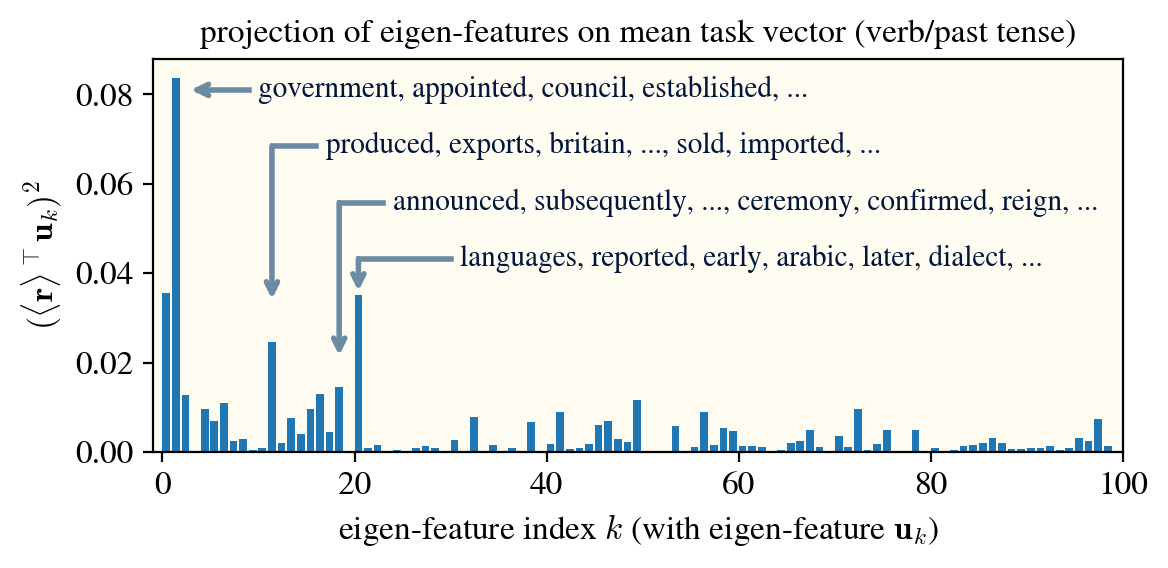

In [ ]:
def add_arrow(ax, p1, p2):
    x1, y1, x2, y2 = *p1, *p2
    x2p = x2 if y1!=y2 else x2-1
    color = "xkcd:grey blue"
    ax.plot((x1, x2+.1), (y1, y1), lw=2, color=color)
    ax.add_patch(FancyArrowPatch((x2, y1), (x2p, y2), mutation_scale=10, arrowstyle="->",
                                 color=color, shrinkA=0, shrinkB=0, lw=2))

def set_localization_plot(ax, R):
    d = 100
    R_d = R[:, :d]
    N, d = R_d.shape
    mean = R_d.T @ (np.ones(N) / N)
    power = mean**2
    power /= power.sum()

    ax.bar(np.arange(d), power, align="edge")
    ax.set_xlabel(f"eigen-feature index $k$ (with eigen-feature $\\mathbf{{u}}_k$)")
    ax.set_ylabel(f"$(\\langle \\mathbf{{r}}\\rangle^\\top \\mathbf{{u}}_k)^2$")
    ax.set_title(f"projection of eigen-features on mean task vector (verb/past tense)",
                fontsize=12)
    ax.set_xlim(-1, d)

    f = 18
    textcolor = "xkcd:navy"
    fs = 10.5
    ax.text(10, f*.0045, "government, appointed, council, established, ...",
            verticalalignment="center", color=textcolor, fontsize=fs)
    add_arrow(ax, (9, f*.0045), (4, f*.0045))
    ax.text(17, f*.0038, "produced, exports, britain, ..., sold, imported, ...",
            verticalalignment="center", color=textcolor, fontsize=fs)
    add_arrow(ax, (16, f*.0038), (11.4, f*.0019))
    ax.text(24, f*.0031, "announced, subsequently, ..., ceremony, confirmed, reign, ...",
            verticalalignment="center", color=textcolor, fontsize=fs)
    add_arrow(ax, (23, f*.0031), (18.4, f*.0012))
    ax.text(31, f*.0024, "languages, reported, early, arabic, later, dialect, ...",
            verticalalignment="center", color=textcolor, fontsize=fs)
    add_arrow(ax, (30, f*.0024), (20.4, f*.002))


fig, ax = plt.subplots(figsize=(6,3))
set_localization_plot(ax, R)
plt.tight_layout()
plt.show()

# Marchenko Pastur

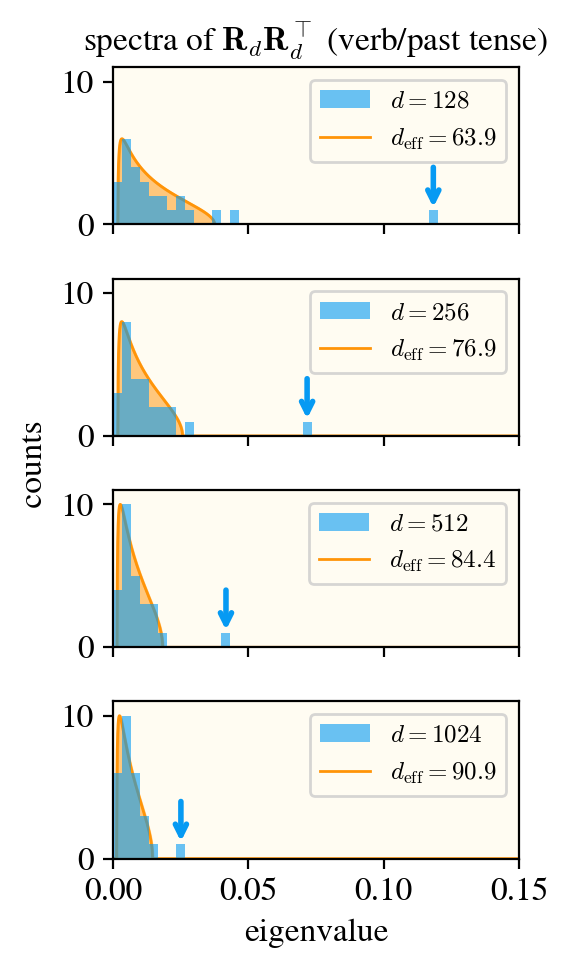

In [195]:
def estim_sigma2(R_d):
    R_d = R_d - R_d.mean(axis=0, keepdims=True)
    sigma2 = np.mean(R_d**2)
    return sigma2

def estim_d_eff(R_d, outliers=0):
    n, d = R_d.shape
    sigma2 = estim_sigma2(R_d)
    Rcent = R_d - R_d.mean(axis=0, keepdims=True)
    C = (Rcent @ Rcent.T) / d
    eigva = np.linalg.eigvalsh(C)
    upper = eigva[-(1+outliers)]
    gamma_est = (np.sqrt(upper / sigma2) - 1)**2
    d_eff = n / gamma_est
    return d_eff

def mp_distro(lam, N, d, sigma2=0.01):
    gamma = N/d
    lam_scaled = lam / sigma2
    lb = (1 - np.sqrt(gamma))**2
    ub = (1 + np.sqrt(gamma))**2
    density = np.zeros_like(lam)
    support = (lam_scaled >= lb) & (lam_scaled <= ub)
    density[support] = np.sqrt((ub - lam_scaled[support]) * (lam_scaled[support] - lb)) / (2 * np.pi * gamma * lam_scaled[support])
    return density / sigma2

def set_mp_plot(axes, R):
    dd = [128, 256, 512, 1024]
    assert len(dd) == len(axes)
    fudge = {
        8: 1,
        64: 1.15,
        128: 1.3,
        256: 1.1,
        512: 1,
        1024: 1,
        2048: 1,
    }
    N = R.shape[0]

    xmax = .15
    xx = np.linspace(0, xmax, 1000)

    for i, ax in enumerate(axes):
        d = dd[i]

        R_d = R[:, :d]
        eigvals = np.linalg.eigvalsh((1/d) * R_d @ R_d.T)
        sigma2 = estim_sigma2(R_d)
        d_eff = estim_d_eff(R_d, outliers=1)
        d_eff *= fudge[d]

        counts, bins, _ = ax.hist(eigvals, bins=int(300*xmax), range=(0, xmax),
                                     color="xkcd:azure", alpha=0.6,
                                     label=f"$d={d}$")
        idx = np.where(counts > 0)[0][-1]
        ax.add_patch(FancyArrowPatch((bins[idx]+.0017, 4), (bins[idx]+.0017, 1.2), mutation_scale=10, arrowstyle="->",
                                 color="xkcd:azure", shrinkA=0, shrinkB=0, lw=2))


        th = mp_distro(xx, N, d_eff, sigma2=sigma2)
        th *= counts.max()/(th.max()+1e-15)
        mp_color = "xkcd:tangerine"
        ax.fill_between(xx, th, color=mp_color, alpha=0.5, zorder=-4)
        ax.plot(xx, th, color=mp_color, alpha=1, lw=1, zorder=-4,
                label=f"$d_\\mathrm{{eff}}={d_eff:.1f}$")

        ax.set_xlim(0, xmax)
        ax.set_ylim(0, 11)

    
        ax.legend(fontsize=9)

    axes[0].set_title(f"spectra of $\\mathbf{{R}}_d\\mathbf{{R}}_d^\\top$ (verb/past tense)")
    axes[-1].set_xlabel("eigenvalue")
    axes[2].set_ylabel(" "*25 + "counts")

family = "verb-preterite"
category = catname2category[family]
R =get_R(W, family)
fig, axes = plt.subplots(nrows=4, figsize=(3,5), sharex=True)
set_mp_plot(axes, R)
plt.tight_layout()
plt.show()

# Spike strength

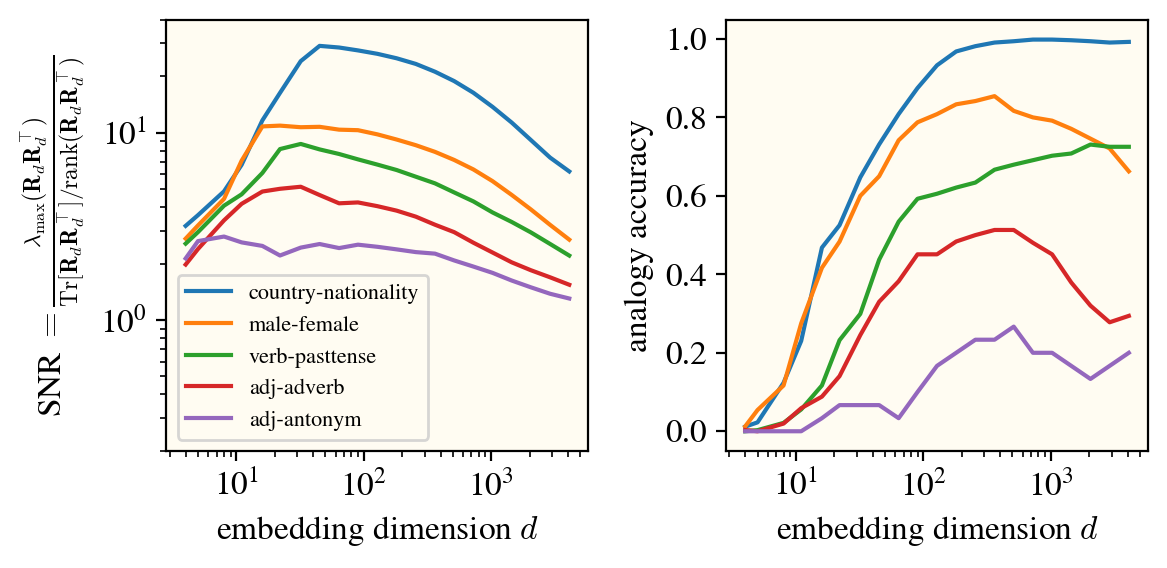

In [77]:
def set_spike_plot(axes, families):
    ax1, ax2 = axes
    for fam in families:
        label = fam if fam!="verb-preterite" else "verb-pasttense"
        ax1.plot(dd, snrs_f[fam], label=label)
        ax2.plot(dd, accs_f[fam], label=label)

    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylim(.2, 40)
    ax1.set_xlabel(f"embedding dimension $d$")
    lmax_str = f"\\lambda_\\mathrm{{max}}(\\mathbf{{R}}_d\\mathbf{{R}}_d^\\top)"
    tr_str = f"\\mathrm{{Tr}}[\\mathbf{{R}}_d\\mathbf{{R}}_d^\\top] \
        / \\mathrm{{rank}}(\\mathbf{{R}}_d\\mathbf{{R}}_d^\\top)"
    ax1.set_ylabel(f"SNR $= \\frac{{{lmax_str}}}{{{tr_str}}}$")
    ax1.legend(fontsize=8, loc='lower left', bbox_to_anchor=(0, 0))

    ax2.set_xscale("log")
    ax2.set_xlabel(f"embedding dimension $d$")
    ax2.set_ylabel(f"analogy accuracy")

fig, axes = plt.subplots(ncols=2, figsize=(6,3))
set_spike_plot(axes, families)
plt.tight_layout()
plt.show()

# Plot

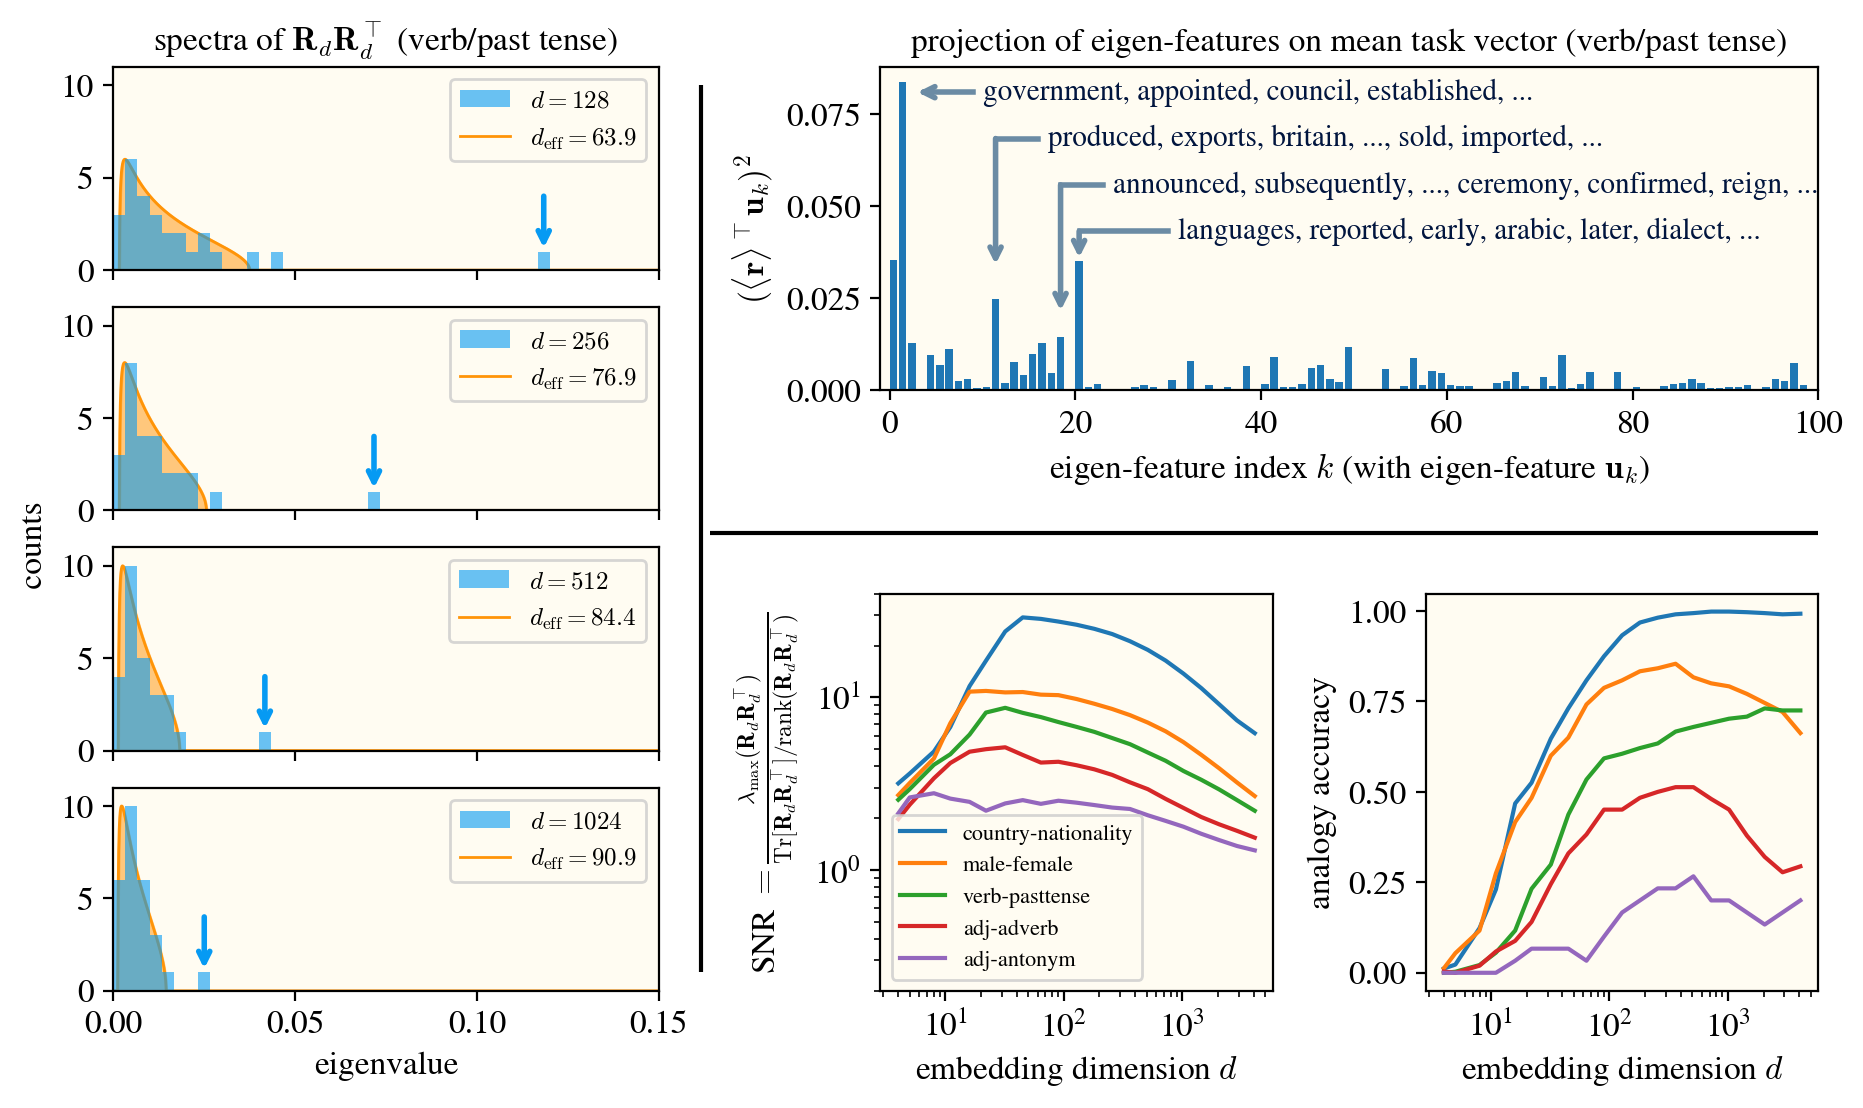

In [198]:
fig = plt.figure(figsize=(11, 6))
gs = fig.add_gridspec(100, 100, wspace=0, hspace=0)

family = "verb-preterite"
category = catname2category[family]
R =get_R(W, family)

ax_loc = fig.add_subplot(gs[0:35, 45:100])
set_localization_plot(ax_loc, R)

axes_snr = [
    fig.add_subplot(gs[57:100, 45:68]),
    fig.add_subplot(gs[57:100, 77:100]),
]
set_spike_plot(axes_snr, families)

axes_mp = [
    fig.add_subplot(gs[0:22, 0:32]),
    fig.add_subplot(gs[26:48, 0:32]),
    fig.add_subplot(gs[52:74, 0:32]),
    fig.add_subplot(gs[78:100, 0:32]),
]
for ax in axes_mp[:-1]:
    ax.tick_params(axis='x', labelbottom=False)
set_mp_plot(axes_mp, R)

ax = fig.add_subplot(gs[50, 35:100])
ax.plot([0, 1], [0, 0], color='black', linestyle='-')
ax.axis('off')
ax.set_xlim(0,1)
ax.tick_params(axis='both', labelleft=False)

ax = fig.add_subplot(gs[2:98, 34])
ax.plot([0, 0], [0, 1], color='black', linestyle='-')
ax.axis('off')
ax.set_ylim(0,1)
ax.tick_params(axis='both', labelleft=False)

plt.savefig('fig4.pdf', format='pdf', bbox_inches='tight')